## 参考pdf文档构建全连接神经网络，解决金融信用评级问题
### 要求
#### 1. 复现代码
#### 2. 构建一个6层以上的全连接神经网络解决问题

In [17]:
import pandas as pd 
from sklearn import preprocessing 
import torch 
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

In [18]:
#读取文件 
data = pd.read_csv("application.csv") 
data.head() 

,SK_ID_CURR,TARGET,INCOME_TOTAL,CREDIT,ANNUITY,GOODS_PRICE,INCOME_TYPE,HOUR_APPR,ORGANIZATION_TYPE
0,100002,1,202500.0,406597.5,24700.5,351000.0,Working,10,Business Entity Type 3
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,State servant,11,School
2,100004,0,67500.0,135000.0,6750.0,135000.0,Working,9,Government
3,100006,0,135000.0,312682.5,29686.5,297000.0,Working,17,Business Entity Type 3
4,100007,0,121500.0,513000.0,21865.5,513000.0,Working,11,Religion


In [19]:
# 统计空值 
null_counts = data.isnull().sum() 
print(null_counts) 
# 删除包含空值的行 
data = data.dropna() 
# 打印删除空值后的数据集信息 
print(data.info())

SK_ID_CURR             0
TARGET                 0
INCOME_TOTAL           0
CREDIT                 0
ANNUITY               12
GOODS_PRICE          278
INCOME_TYPE            0
HOUR_APPR              0
ORGANIZATION_TYPE      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 307221 entries, 0 to 307510
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SK_ID_CURR         307221 non-null  int64  
 1   TARGET             307221 non-null  int64  
 2   INCOME_TOTAL       307221 non-null  float64
 3   CREDIT             307221 non-null  float64
 4   ANNUITY            307221 non-null  float64
 5   GOODS_PRICE        307221 non-null  float64
 6   INCOME_TYPE        307221 non-null  object 
 7   HOUR_APPR          307221 non-null  int64  
 8   ORGANIZATION_TYPE  307221 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 23.4+ MB
None


In [20]:
# 创建 LabelEncoder 对象，用于对标签进行编码 
label_encoder = preprocessing.LabelEncoder() 
# 将 'INCOME_TYPE' 字段的标签进行编码 
data['INCOME_TYPE'] = label_encoder.fit_transform(data['INCOME_TYPE']) 
# 将 'ORGANIZATION_TYPE' 字段的标签进行编码 
data['ORGANIZATION_TYPE'] = label_encoder.fit_transform(data['ORGANIZATION_TYPE']) 
data.head()

,SK_ID_CURR,TARGET,INCOME_TOTAL,CREDIT,ANNUITY,GOODS_PRICE,INCOME_TYPE,HOUR_APPR,ORGANIZATION_TYPE
0,100002,1,202500.0,406597.5,24700.5,351000.0,7,10,5
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,4,11,39
2,100004,0,67500.0,135000.0,6750.0,135000.0,7,9,11
3,100006,0,135000.0,312682.5,29686.5,297000.0,7,17,5
4,100007,0,121500.0,513000.0,21865.5,513000.0,7,11,37


In [21]:
# 分割特征和标签 
X = data.drop(columns=["TARGET", "SK_ID_CURR"]).values 
y = data["TARGET"].values.reshape(-1, 1) 
X.shape 
 
# 数据标准化 
scaler = StandardScaler() 
X = scaler.fit_transform(X) 
 
# 划分训练集和测试集 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
random_state=42) 
 
# 转换为张量 
X_train = torch.tensor(X_train, dtype=torch.float32) 
y_train = torch.tensor(y_train, dtype=torch.float32) 
X_test = torch.tensor(X_test, dtype=torch.float32) 
y_test = torch.tensor(y_test, dtype=torch.float32) 

In [22]:
# 定义神经网络模型 
class Net(nn.Module): 
    def __init__(self): 
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(7, 64) 
        self.fc2 = nn.Linear(64, 32) 
        self.fc3 = nn.Linear(32, 32) 
        self.fc4 = nn.Linear(32, 32) 
        self.fc5 = nn.Linear(32, 32) 
        self.fc6 = nn.Linear(32, 16) 
        self.fc7 = nn.Linear(16, 2)  # 输出层为2，对应两个类别 
         
    def forward(self, x): 
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x)) 
        x = torch.relu(self.fc3(x)) 
        x = torch.relu(self.fc4(x)) 
        x = torch.relu(self.fc5(x)) 
        x = torch.relu(self.fc6(x)) 
        x = self.fc7(x) 
        return x 
     
# 初始化模型 
model = Net()   

In [23]:
# 定义损失函数和优化器 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 
 
# 训练模型 
num_epochs = 15 
train_losses = [] 
train_accs = [] 
test_accs = [] 
for epoch in range(num_epochs): 
    # 前向传播 
    outputs = model(X_train) 
    loss = criterion(outputs, y_train.squeeze().long()) 
     
    # 反向传播和优化 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
     
    # 计算训练集准确率 
    _, predicted = torch.max(outputs, 1) 
    train_acc = (predicted == y_train.squeeze().long()).sum().item() / y_train.shape[0] 
     
    # 计算测试集准确率 
    with torch.no_grad(): 
        test_outputs = model(X_test) 
        _, predicted = torch.max(test_outputs, 1) 
        test_acc = (predicted == y_test.squeeze().long()).sum().item() / y_test.shape[0] 
     
    # 保存损失和准确率 
    train_losses.append(loss.item()) 
    train_accs.append(train_acc) 
    test_accs.append(test_acc) 
     
    # 输出训练信息 
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, TrainAcc: {train_acc:.4f}, Test Acc: {test_acc:.4f}") 

Epoch 1/15, Loss: 0.7244, TrainAcc: 0.0801, Test Acc: 0.0823
Epoch 2/15, Loss: 0.7212, TrainAcc: 0.0801, Test Acc: 0.0823
Epoch 3/15, Loss: 0.7180, TrainAcc: 0.0801, Test Acc: 0.0823
Epoch 4/15, Loss: 0.7147, TrainAcc: 0.0801, Test Acc: 0.0823
Epoch 5/15, Loss: 0.7112, TrainAcc: 0.0801, Test Acc: 0.0824
Epoch 6/15, Loss: 0.7077, TrainAcc: 0.0802, Test Acc: 0.0825
Epoch 7/15, Loss: 0.7041, TrainAcc: 0.0804, Test Acc: 0.0845
Epoch 8/15, Loss: 0.7004, TrainAcc: 0.0823, Test Acc: 0.1198
Epoch 9/15, Loss: 0.6965, TrainAcc: 0.1180, Test Acc: 0.5974
Epoch 10/15, Loss: 0.6923, TrainAcc: 0.6004, Test Acc: 0.9177
Epoch 11/15, Loss: 0.6879, TrainAcc: 0.9199, Test Acc: 0.9177
Epoch 12/15, Loss: 0.6832, TrainAcc: 0.9199, Test Acc: 0.9177
Epoch 13/15, Loss: 0.6781, TrainAcc: 0.9199, Test Acc: 0.9177
Epoch 14/15, Loss: 0.6726, TrainAcc: 0.9199, Test Acc: 0.9177
Epoch 15/15, Loss: 0.6666, TrainAcc: 0.9199, Test Acc: 0.9177


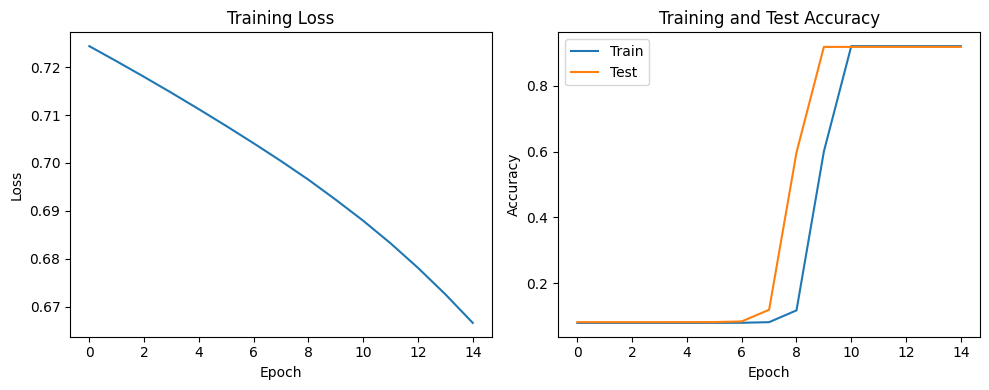

In [24]:
plt.figure(figsize=(10, 4)) 
plt.subplot(1, 2, 1) 
plt.plot(train_losses) 
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.title("Training Loss") 

plt.subplot(1, 2, 2) 
plt.plot(train_accs, label="Train") 
plt.plot(test_accs, label="Test") 
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 
plt.title("Training and Test Accuracy") 
plt.legend() 

plt.tight_layout() 
plt.show() 